#https://www.kaggle.com/werooring/top-9th-lightgbm-xgboost-ensemble

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

- ind_cat / ind_bin
- reg : float
- car : int& float / car_cat
- calc : float / int / calc_bin

In [13]:
#train['ps_ind_18_bin'].unique()

array([0, 1])

In [100]:
all_data = pd.concat([train,test],ignore_index = True)
all_data = all_data.drop('target',axis = 1)

all_features = all_data.columns.tolist()

Generate missing values as a new feature

In [101]:
#Add number of missing value per data
all_data['num_missing'] = (all_data == -1).sum(axis = 1)# -1이  missing value 이므로

remaining_features = [col for col in all_features \
                     if( 'cat' not in col and 'calc' not in col)]

remaining_features.append('num_missing')

In [75]:
all_data['num_missing'].value_counts()

2    637430
1    391628
0    311498
3    140202
4      7062
7       142
6        48
8        13
5         5
Name: num_missing, dtype: int64

In [102]:
#Onehot encoding
from sklearn.preprocessing import OneHotEncoder

cat_features = [col for col in all_features if 'cat' in col] #Nominal features

ecn = OneHotEncoder()
ecn_cat_matrix = ecn.fit_transform(all_data[cat_features])

Create a new features mix_ind that combines unique values of an ind features  
    : Feature with 'ind' on tag

In [103]:
ind_features = [col for col in all_features if 'ind' in col]

first_col = True
for col in ind_features:
    if first_col:
        all_data['mix_ind'] = all_data[col].astype(str)+'_'
        first_col = False
    else:
        all_data['mix_ind'] += all_data[col].astype(str)+'_'

In [78]:
all_data['mix_ind'].value_counts()

0_2_1_0_0_1_0_0_0_0_0_0_0_0_7_1_0_0_     2992
0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_     2784
0_1_2_0_0_1_0_0_0_0_0_0_0_0_7_1_0_0_     2568
0_1_1_0_0_1_0_0_0_0_0_0_0_0_7_1_0_0_     2174
0_2_0_0_0_1_0_0_0_0_0_0_0_0_7_1_0_0_     2131
                                         ... 
3_2_0_1_0_0_0_0_1_0_0_0_0_0_10_1_0_0_       1
7_1_7_1_0_0_1_0_0_0_0_0_0_0_4_0_1_0_        1
4_1_7_0_6_0_0_1_0_0_0_0_0_0_5_0_0_1_        1
5_1_4_0_0_0_0_1_0_0_0_1_1_2_0_0_0_1_        1
3_1_8_1_0_0_0_1_0_0_0_0_0_0_12_0_0_0_       1
Name: mix_ind, Length: 143769, dtype: int64

In [79]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [104]:
#Create new feature, the number of eigenvalues for nominal features
cat_count_features = []
for col in cat_features + ['mix_ind']:
    val_counts_dic = all_data[col].value_counts().to_dict()
    all_data[f'{col}_count'] = all_data[col].apply(lambda x:val_counts_dic[x])
    cat_count_features.append(f'{col}_count')

In [30]:
all_data[col]

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

In [105]:
from scipy import sparse
drop_features = ['ps_ind_14', 'ps_ind_10_bin','ps_ind_11_bin', 
                 'ps_ind_12_bin','ps_ind_13_bin','ps_car_14'] #unbalanced data

all_data_remaining = all_data[remaining_features + cat_count_features].drop(drop_features, axis = 1)

all_data_spars = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               ecn_cat_matrix],
                              format='csr') #hstack 배열 수평 결합 with CSR
                                            #CSR(Compressed sparse row) : 
                                            #가로의 순서대로 재정렬하는 방법으로 행에 관여하여 정리 압축한 것을 CSR이라고 한다
#참고할만한 사이트 > https://radish-greens.tistory.com/1

In [106]:
#Data split
num_train = train.shape[0]

X = all_data_spars[:num_train]
X_test = all_data_spars[num_train:]

y=train['target'].values

In [107]:
#Evaluation Metrics : GINI
def eval_gini(y_true, y_pred):
    # Verify that the actual and predicted values are the same size (different values raise errors)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0] # Number of data
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # Diagonal value

    # 1) Gini coefficient for predicted values
    pred_order = y_true[y_pred.argsort()] # Sort y_true values by y_pred size
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # Lorentz Curve
    G_pred = np.sum(L_mid - L_pred) # Gini coefficient for predicted values

    # 2) Gini coefficient when prediction is perfect
    true_order = y_true[y_true.argsort()] # Sort y_true values by y_true size
    L_true = np.cumsum(true_order) / np.sum(true_order) # Lorentz Curve
    G_true = np.sum(L_mid - L_true) #  Gini coefficient when prediction is perfect

    # Normalized Gini coefficient
    return G_pred / G_true

In [108]:
def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

In [109]:
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

In [110]:
#Modeling
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

In [54]:
#lgbm
max_params_lgb = {'bagging_fraction': 0.8043696643500143,
 'feature_fraction': 0.6829323879981047,
 'lambda_l1': 0.9264555612104627,
 'lambda_l2': 0.9774233689434216,
 'min_child_samples': 10,
 'min_child_weight': 125.68433948868649,
 'num_leaves': 28,
 'objective': 'binary',
 'learning_rate': 0.01,
 'bagging_freq': 1,
 'verbosity': 0,
 'random_state': 1991}

In [55]:
import lightgbm as lgbm

# One-dimensional array of probabilities for predicting validation data target values with an OOF-trained model
oof_val_preds_lgb = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values with an OOF-trained model
oof_test_preds_lgb = np.zeros(X_test.shape[0]) 

# Train, validate, and predict models by OOF
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {idx+1} out of {folds.n_splits}', '#'*40)
    
    # Set train data, valid data
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Create lgbm dataset
    dtrain = lgbm.Dataset(X_train, y_train) # lgbm train dataset
    dvalid = lgbm.Dataset(X_valid, y_valid) # lgbm valid dataset

    # Train LightGBM
    lgb_model = lgbm.train(params=max_params_lgb, # Optimal Hyper-parameters
                           train_set=dtrain, # Train data
                           num_boost_round=1500, # Number of boosting iterations
                           valid_sets=dvalid, # Valid data for model performance evaluation
                           feval=gini_lgb, # Evaluation metrics for validation
                           early_stopping_rounds=150, # Early stopping condition
                           verbose_eval=100)
    
    # The number of boosting iterations when the model performs best 
    best_iter = lgb_model.best_iteration
    # Predict probabilities using test data
    oof_test_preds_lgb += lgb_model.predict(X_test, 
                                    num_iteration=best_iter)/folds.n_splits
    # OOF prediction for model performance evaluation
    oof_val_preds_lgb[valid_idx] += lgb_model.predict(X_valid, num_iteration=best_iter)
    
    # Normalized Gini coefficient for oof prediction probabilities
    gini_score = eval_gini(y_valid, oof_val_preds_lgb[valid_idx])
    print(f'Fold {idx+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 150 rounds
[100]	valid_0's binary_logloss: 0.153313	valid_0's gini: 0.26991
[200]	valid_0's binary_logloss: 0.152355	valid_0's gini: 0.279633
[300]	valid_0's binary_logloss: 0.151926	valid_0's gini: 0.286347
[400]	valid_0's binary_logloss: 0.151693	valid_0's gini: 0.291197
[500]	valid_0's binary_logloss: 0.151558	valid_0's gini: 0.294222
[600]	valid_0's binary_logloss: 0.151476	valid_0's gini: 0.296027
[700]	valid_0's binary_logloss: 0.15142	valid_0's gini: 0.297357
[800]	valid_0's binary_logloss: 0.151378	valid_0's gini: 0.298398
[900]	valid_0's binary_logloss: 0.151348	valid_0's gini: 0.299141
[1000]	valid_0's bi

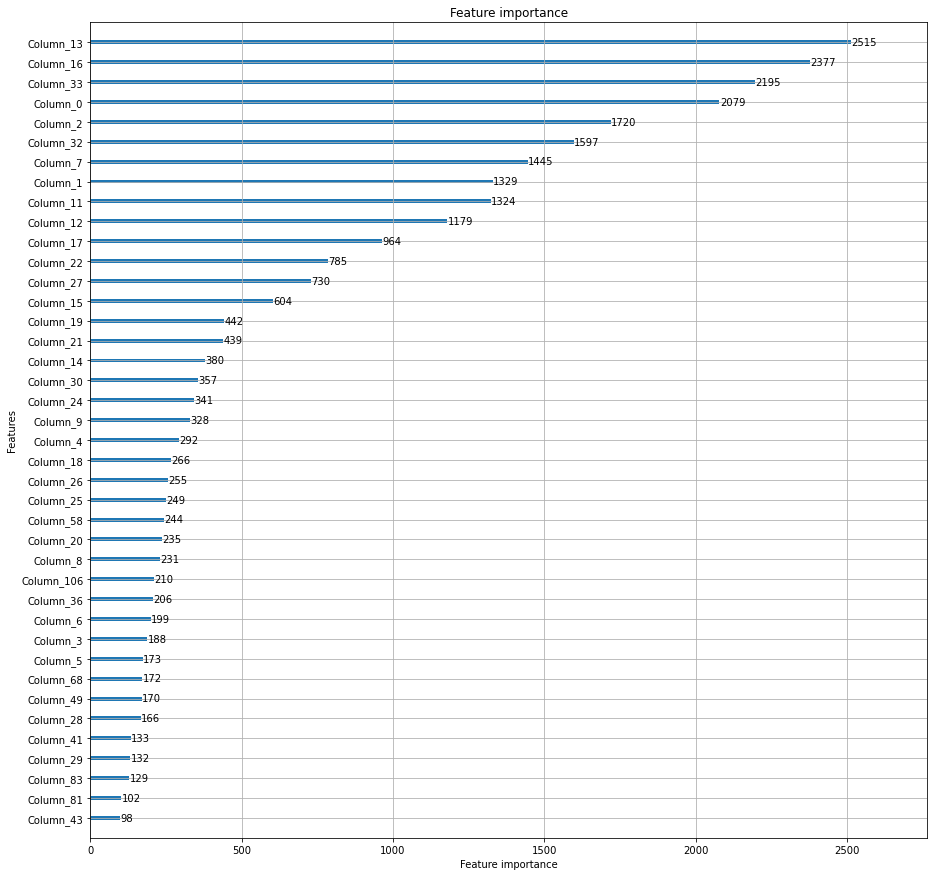

In [96]:
ax = lgbm.plot_importance(lgb_model, max_num_features=40, figsize=(15,15))
plt.show()

In [56]:
#xgboost
max_params_xgb = {'colsample_bytree': 0.8927325521002059,
 'gamma': 9.766883037651555,
 'max_depth': 7,
 'min_child_weight': 6.0577898395058085,
 'reg_alpha': 8.136089122187865,
 'reg_lambda': 1.385119327658532,
 'scale_pos_weight': 1.5142072116395773,
 'subsample': 0.717425859940308,
 'objective': 'binary:logistic',
 'learning_rate': 0.05,
 'random_state': 1991}

In [57]:
import xgboost as xgb

# One-dimensional array of probabilities for predicting validation data target values with an OOF-trained model
oof_val_preds_xgb = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values with an OOF-trained model
oof_test_preds_xgb = np.zeros(X_test.shape[0]) 

# Train, validate, and predict models by OOF
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {idx+1} out of {folds.n_splits}', '#'*40)
    
    # Set train data, valid data
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # Create xgboost dmatrix
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    xgb_model = xgb.train(params=max_params_xgb, 
                           dtrain=dtrain,
                           num_boost_round=1000,
                           evals=watchlist,
                          maximize=True,
                           feval=gini_xgb,
                           early_stopping_rounds=150,
                           verbose_eval=100)

    # The number of boosting iterations when the model performs best 
    best_iter = xgb_model.best_iteration
    # Predict probabilities using test data
    oof_test_preds_xgb += xgb_model.predict(dtest, 
                                    ntree_limit=best_iter)/folds.n_splits
    # OOF prediction for model performance evaluation
    oof_val_preds_xgb[valid_idx] += xgb_model.predict(dvalid, ntree_limit=best_iter)
    
    # Normalized Gini coefficient for oof prediction probabilities
    gini_score = eval_gini(y_valid, oof_val_preds_xgb[valid_idx])
    print(f'Fold {idx+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
[01:31:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.65258	train-gini:0.15851	valid-logloss:0.65282	valid-gini:0.15941
[100]	train-logloss:0.15541	train-gini:0.31140	valid-logloss:0.15638	valid-gini:0.28408
[200]	train-logloss:0.15293	train-gini:0.34519	valid-logloss:0.15487	valid-gini:0.29439
[300]	train-logloss:0.15205	train-gini:0.36650	valid-logloss:0.15478	valid-gini:0.29574
[400]	train-logloss:0.15131	train-gini:0.38496	valid-logloss:0.15476	valid-gini:0.29548
[424]	train-logloss:0.15116	train-gini:0.38814	valid-logloss:0.15475	valid-gini:0.29599


/Users/doyeonpyun/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Fold 1 gini score: 0.296205806085978

######################################## Fold 2 out of 5 ########################################
[01:38:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.65280	train-gini:0.17041	valid-logloss:0.65286	valid-gini:0.15070
[100]	train-logloss:0.15528	train-gini:0.31574	valid-logloss:0.15674	valid-gini:0.26953
[200]	train-logloss:0.15269	train-gini:0.35025	valid-logloss:0.15534	valid-gini:0.27900
[300]	train-logloss:0.15172	train-gini:0.37434	valid-logloss:0.15526	valid-gini:0.28109


KeyboardInterrupt: 

In [70]:
cat_params = {'n_est' : 2000,
                'seed' : 42,
                'n_fold' : 15,
                'n_class' : 3}

In [85]:
from catboost import CatBoostClassifier, Pool

# One-dimensional array of probabilities for predicting validation data target values with an OOF-trained model
oof_val_preds_cat = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values with an OOF-trained model
oof_test_preds_cat = np.zeros(X_test.shape[0]) 

# Train, validate, and predict models by OOF
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {idx+1} out of {folds.n_splits}', '#'*40)
    
    # Set train data, valid data
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Train LightGBM
    cat_model = CatBoostClassifier(, # Optimal Hyper-parameters
                           train_set=dtrain, # Train data
                           num_boost_round=1500, # Number of boosting iterations
                           valid_sets=dvalid, # Valid data for model performance evaluation
                           feval=gini_lgb, # Evaluation metrics for validation
                           early_stopping_rounds=150, # Early stopping condition
                           verbose_eval=100)
    
    # The number of boosting iterations when the model performs best 
    best_iter = cat_model.best_iteration
    # Predict probabilities using test data
    oof_test_preds_cat += cat_model.predict(X_test, 
                                    num_iteration=best_iter)/folds.n_splits
    # OOF prediction for model performance evaluation
    oof_val_preds_cat[valid_idx] += cat_model.predict(X_valid, num_iteration=best_iter)
    
    # Normalized Gini coefficient for oof prediction probabilities
    gini_score = eval_gini(y_valid, oof_test_preds_cat[valid_idx])
    print(f'Fold {idx+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################


TypeError: __init__() got an unexpected keyword argument 'params'